# General-purpose imports

In [1]:
import copy
import numpy as np
import os
import pandas as pd
import sys
import torch
import torchvision
import torchvision.transforms.v2 as T

from itertools import product
from matplotlib import pyplot as plt
from PIL import Image
from torch import nn
from torch.utils.data import Dataset
from tqdm import tqdm

# GPU or CPU

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cpu


# Constants

## Experiment settings

In [ ]:
TARGET_CLASS = 0

ATTACKS = [
    # "badnet",
    # "blended",
    # "wanet",
    # "bpp",
    "adaptive_patch",
    # "adaptive_blend",
    # "dfst",
    # "narcissus",
    # "grond",
    # "dfba"
]

# resnet18 or vgg16
MODEL_ARCH = "resnet18"

# cifar10, cifar100 or imagenette
DATASET = "cifar10"

POISON_RATES = [
    lambda atk: 0.007 if DATASET == "cifar100" and atk in ["narcissus", "grond"] else 0.05,
    lambda atk: 0.02 if DATASET == "cifar10" and atk in ["wanet", "bpp"] else 0.003
]

## Constants dependent on experiment settings

In [4]:
BATCH_SIZE = 20 if DATASET == "imagenette" else 100

# Highest poison rate when comparing or visualizing trainset stealthiness 
DEFAULT_POISON_RATE = POISON_RATES[0]

# Below constants allow multiple datasets and model architectures to be compared at the same time
# We use this for one input-space stealthiness experiment
MODEL_ARCHITECTURES = [MODEL_ARCH]
DATASETS = [DATASET]

N_CLASSES_DICT = {
    "cifar10": 10,
    "cifar100": 100,
    "imagenette": 10
}

IMG_SIZE_DICT = {
    "cifar10": (32, 32),
    "cifar100": (32, 32),
    "imagenette": (80, 80)
}

# Which index to use when comparing poisoned images, for each dataset
IMG_INDEX_DICT = {
    "cifar10": {
        "train": [3, 50, 72, -4],
        "test": 4
    },
    "cifar100": {
        "train": [1, 11, 15, 21],
        "test": 206
    },
    "imagenette": {
        "train": [2, 3, 12, 4],
        "test": 17
    }
}

ATK_PPRINT_DICT = {
    "badnet": "BadNets",
    "blended": "Blend",
    "wanet": "WaNet",
    "bpp": "BppAttack",
    "adaptive_patch": "Adap-Patch",
    "adaptive_blend": "Adap-Blend",
    "dfst": "DFST",
    "dfba": "DFBA",
    "narcissus": "Narcissus",
    "grond": "Grond"
}

## Dataset augmentation

In [5]:
NORMALIZATION_DICT = {
    "cifar10": ([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
    "cifar100": ([0.5071, 0.4865, 0.4409], [0.2673, 0.2564, 0.2762]),
    "imagenette": ([0.4671, 0.4593, 0.4306], [0.2692, 0.2657, 0.2884])
}

TO_TENSOR_LIST = [T.ToImage(), T.ToDtype(torch.float32, scale=True)]
TRANSFORM_DICT = {}

for dataset in DATASETS:
    for split in ["train", "test", "train_transformed", "test_transformed"]:
        transforms = []
        img_size = IMG_SIZE_DICT[dataset]
        
        if split == "train_transformed":
            transforms += [T.RandomCrop(img_size, 4), T.RandomRotation(10)]

            if dataset == "cifar10":
                transforms.append(T.RandomHorizontalFlip())

        transforms += TO_TENSOR_LIST

        # Different normalization per dataset
        if "transformed" in split:
            mean, std = NORMALIZATION_DICT[dataset]
            normalize = T.Normalize(mean, std)
            transforms.append(normalize)

        TRANSFORM_DICT[f"{dataset}_{split}"] = T.Compose(transforms)

## File paths

In [6]:
DATA_DIR = "data"
RECORD_DIR = "record"
RESULT_DIR = "results"

# Utils

## Benign Datasets

In [7]:
class Imagenette(torchvision.datasets.VisionDataset):
    """Custom torchvision implementation of the Imagenette dataset.

    Unlike the official torchvision implementation of this dataset, this class has a 'data' attribute, which contains tensors representing all images.
    This way, our code can handle Imagenette the same way as CIFAR-10 and CIFAR-100, which already have a data attribute in their official torchvision implementation."""

    def __init__(self, root=None, train=True, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)

        split = "train" if train else "val"
        img_folder = torchvision.datasets.ImageFolder(os.path.join(self.root, split))

        self.classes = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
        self.data = []
        self.targets = []

        for img_path, label in img_folder.samples:
            img = np.array(Image.open(img_path).convert("RGB"))

            if len(img.shape) != 3:
                print(img_path)
                
            self.data.append(img)
            self.targets.append(label)

        self.data = np.stack(self.data)

    # Copied from CIFAR-10(0) implementation
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target
    
    # Copied from CIFAR-10(0) implementation
    def __len__(self):
        return len(self.data)

## Backdoor Datasets

In [8]:
class BackdoorDataset(Dataset):
    def __init__(self, bd_dataset, classes, target_class, original_labels, poison_lookup, cross_lookup=None):
        self.bd_dataset = bd_dataset
        self.classes = classes
        self.target_class = target_class
        self.original_labels = original_labels
        self.poison_lookup = poison_lookup
        self.cross_lookup = cross_lookup

        # Create the poisoned labels by copying the original labels, and setting the poisoned indices to the target class
        self.poisoned_labels = self.original_labels.copy()
        self.poisoned_labels[self.poison_lookup] = self.target_class

    def __len__(self):
        return len(self.bd_dataset)
    
    def __getitem__(self, index):
        return self.bd_dataset.__getitem__(index) 
    
# Wrapper around BackdoorBench's utils.bd_dataset_v2.dataset_wrapper_with_transform
class BackdoorBenchDataset(BackdoorDataset):
    def __init__(self, bb_dataset, target_class, replace_transform=None):
        classes = bb_dataset.wrapped_dataset.dataset.classes
        original_labels = np.array(bb_dataset.wrapped_dataset.dataset.targets)
        poison_lookup = bb_dataset.wrapped_dataset.poison_indicator == 1
        cross_lookup = bb_dataset.wrapped_dataset.poison_indicator == 2

        if replace_transform:
            bb_dataset.wrap_img_transform = replace_transform

        super().__init__(bb_dataset, classes, target_class, original_labels, poison_lookup, cross_lookup)

    # BackdoorBench dataset returns more than just the image and label
    def __getitem__(self, index):
        img, bd_label, dataset_idx, poison_bit, clean_label = self.bd_dataset.__getitem__(index) 
                       
        return img, bd_label

# Convert Adap-Blend/Patch folder of poisoned images to BackdoorDataset child class  
class AdapDataset(BackdoorDataset):
    def __init__(self, bd_record_path, target_class, split, clean_dataset):
        bd_dataset_path = os.path.join(bd_record_path, "data", split)
        bd_dataset = copy.deepcopy(clean_dataset)

        classes = clean_dataset.classes
        original_labels = np.array(clean_dataset.targets)
        n_samples = len(clean_dataset)

        if split == "train":
            poison_indices = torch.load(os.path.join(bd_record_path, "poison_indices"))
            cover_indices = torch.load(os.path.join(bd_record_path, "cover_indices"))
        else:
            poison_indices = range(n_samples)
            cover_indices = []

        # Replace benign images by their poisoned/cross versions for the indices specified above
        for i in np.concat([poison_indices, cover_indices]):
            i = int(i)
            img = Image.open(os.path.join(bd_dataset_path, f"{i}.png"))
            bd_dataset.data[i] = np.asarray(img)

            # Also set label to target class for poisoned images
            if i in poison_indices:
                bd_dataset.targets[i] = target_class

        poison_lookup = np.array([i in poison_indices for i in range(n_samples)])
        cross_lookup = np.array([i in cover_indices for i in range(n_samples)])

        super().__init__(bd_dataset, classes, target_class, original_labels, poison_lookup, cross_lookup)

# Convert DFST poison_data.pt file to BackdoorDataset child class
class DFSTDataset(BackdoorDataset):
    def __init__(self, bd_record_path, target_class, split, clean_dataset):
        classes = clean_dataset.classes
        original_labels = np.array(clean_dataset.targets)
        n_samples = len(clean_dataset)
        bd_dataset = copy.deepcopy(clean_dataset)
        bd_dataset_path = os.path.join(bd_record_path, "poison_data.pt")

        # DFST saves poisoned versions of each image that is not of the target class
        poison_data = torch.load(bd_dataset_path, weights_only=False)
        non_target_poisoned = poison_data[split]

        if split == "train":
            # DFST randomly chooses poisoned samples each batch and epoch and replaces them by poisoned images that are not of the target class
            # These poisoned images are saved to a file
            # We have modified the file to only include a subset of these images according to the poison rate, and have also saved their indices
            poison_indices = poison_data["train_indices"]

            # Mapping from indices in the trainset without the target class to indices in the full trainset
            true_indices = np.arange(n_samples)[original_labels != TARGET_CLASS].squeeze()
        else:
            # The testset is fully poisoned
            poison_indices = range(n_samples)

            # The clean testset also filters the target class, so we do not have to convert the indices
            true_indices = poison_indices 

        # Initialize poison_lookup and cross_lookup
        poison_lookup = np.full(n_samples, False) 
        cross_lookup = np.full(n_samples, False) 

        # Replace benign images by poisoned ones for the poisoned indices in the DFST file, and their corresponding true indices in the dataset
        for i, poison_idx in enumerate(poison_indices):
            true_idx = true_indices[poison_idx]
            poison_lookup[true_idx] = True

            # Get poisoned image, put it in the backdoor dataset and change its label to the target class
            poisoned_img = non_target_poisoned[i]
            bd_dataset.data[true_idx] = (poisoned_img * 255).permute(1, 2, 0).numpy()
            bd_dataset.targets[true_idx] = target_class 

        super().__init__(bd_dataset, classes, target_class, original_labels, poison_lookup, cross_lookup)

# Apply DFBA trigger to benign testset
class DFBADataset(BackdoorDataset):
    def __init__(self, clean_testset, target_class, delta, mask):
        # Get arguments expected by BackdoorDataset
        classes = clean_testset.classes
        original_labels = np.array(clean_testset.targets) # Clean-label attack, so labels do not change
        n_samples = len(clean_testset)
        poison_lookup = np.full(n_samples, True)
        cross_lookup = np.full(n_samples, False) 
        bd_testset = copy.deepcopy(clean_testset)

        # Poison all test images
        for i in range(n_samples):
            # Make color channels first dimension instead of last in order to apply mask to the image
            img = bd_testset.data[i].transpose(2, 0, 1)

            # Combine image and trigger using mask
            bd_img = img * (1 - mask) + (delta * 255) * mask

            # Reverse reordering of dimensions
            bd_testset.data[i] = bd_img.transpose(1, 2, 0)

            # Set label of image to target class
            bd_testset.targets[i] = target_class

        super().__init__(bd_testset, classes, target_class, original_labels, poison_lookup, cross_lookup)

# Add absolute path to ./grond to the system PATH to prevent error in class below
grond_dir = os.path.abspath("./grond")
sys.path.append(grond_dir)
from grond.poison_loader import POI, POI_TEST

# Wrapper around Grond's POI, POI_TEST (abstraction of CIFAR10_POI, CIFAR10_POI_TEST for any dataset)
class GrondDataset(BackdoorDataset):
    def __init__(self, dataset, transform, target_class, record_path, train=True):
        # Reconstruct poisoned dataset used in attack
        if train:
            poison_indices = torch.load(os.path.join(record_path, "poison_indices.pth"))   
            poi_dataset = POI(dataset, root=os.path.join(DATA_DIR, dataset), 
                              poison_rate=None, # poison rate is unused as we pass poison_indices directly
                              transform=transform, poison_indices=poison_indices,
                              target_cls=target_class, upgd_path=record_path)
        else:
            poi_dataset = POI_TEST(dataset, root=os.path.join(DATA_DIR, dataset),
                                   transform=transform, exclude_target=True,
                                   target_cls=target_class, upgd_path=record_path)

        # Get arguments expected by BackdoorDataset
        classes = poi_dataset.cleanset.classes
        original_labels = np.array(poi_dataset.targets) # Clean-label attack, so labels do not change
        n_samples = len(poi_dataset)
        poison_lookup = np.array([i in poison_indices for i in range(n_samples)]) if train else np.full(n_samples, True)
        cross_lookup = np.full(n_samples, False) 

        super().__init__(poi_dataset, classes, target_class, original_labels, poison_lookup, cross_lookup)

## Other

In [9]:
# Create benign test dataset by excluding samples of target class
def filter_target_class(dataset, target_class):
    targets_ndarray = np.array(dataset.targets)
    non_target_class = targets_ndarray != target_class
    dataset.data = dataset.data[non_target_class] 
    dataset.targets = list(np.array(dataset.targets)[non_target_class])

    return dataset

# Feed inputs from dataset to the model in order to extract the predictions
def extract_preds(model, dataset):
    predictions = torch.tensor([])
    dl = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    for in_batch, _ in iter(dl):
        with torch.no_grad():
            pred_batch = model.forward(in_batch.to(DEVICE, non_blocking=True))
            predictions = torch.cat([predictions, pred_batch.cpu().argmax(dim=1)])

    return predictions

# Feed inputs from dataset to the model in order to extract the predictions and features of the specified layer
def extract_preds_and_features(model, dataset, penultimate=True):
    predictions = torch.tensor([])
    features = torch.tensor([])
    dl = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    for in_batch, _ in iter(dl):
        size = len(in_batch) # May be smaller than bs for final batch

        with torch.no_grad():
            # Get features from the penultimate layer
            if penultimate:
                pred_batch, feat_batch = model.forward(in_batch.to(DEVICE, non_blocking=True), return_features=True)
                feat_batch = feat_batch.reshape(size, -1)
            else: # Get features from the layer used to measure TAC in "Towards Backdoor Stealthiness in Model Parameter Space": https://arxiv.org/pdf/2501.05928v1
                pred_batch, feat_batch = model.forward_all_features(in_batch.to(DEVICE, non_blocking=True))
                feat_batch = feat_batch[-1]

            features = torch.cat([features, feat_batch.cpu()])
            predictions = torch.cat([predictions, pred_batch.cpu().argmax(dim=1)])

    return predictions, features

# Given the experiment variable values, create a string identifier to use when loading and saving experiment results
def experiment_variable_identifier(model_arch, dataset, poison_rate):
    if poison_rate == None:
        return f"{model_arch}_{dataset}_pNone"
    else:
        poison_rate_str = "-".join(str(poison_rate).split(".")) # replace . by -
        return f"{model_arch}_{dataset}_p{poison_rate_str}"
    
def list_intersection(a: list, b: list):
    return list(set(a) & set(b))

def dict_subset(dict, keys):
    return {k: v for k, v in dict.items() if k in keys}

# Stealthiness Metrics

## Input-space

In [10]:
"""Implementation of all input-space stealthiness metrics used in the study.

Each metric requires the parameters img1 and img2, which are tensors of shape Nx3xHxW, representing batches of N RGB images of size HxW.
The metrics calculate the mean similarity over the two batches, and they can also be used for single images by passing tensors with N=1.
"""

from numpy.linalg import norm
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips
import torch
from torch.nn.functional import softmax
from scipy.special import rel_entr
from imagehash import phash
import torchvision.transforms.v2 as T
from torchmetrics.functional.image import spectral_angle_mapper

# Load neural networks globally for faster metric calculation
loss_fn = lpips.LPIPS(net="alex", verbose=False).to(DEVICE, non_blocking=True)
inception_v3 = torch.hub.load("pytorch/vision:v0.10.0", "inception_v3", pretrained=True).to(DEVICE, non_blocking=True)
inception_v3.eval()

def lp_norm(p, imgs):
    return np.mean([norm(img.flatten(), ord=p) for img in imgs])

def l1_distance(img1, img2):
    return lp_norm(1, img1 - img2)

def l2_distance(img1, img2):
    return lp_norm(2, img1 - img2)

def linf_distance(img1, img2):
    return lp_norm(np.inf, img1 - img2)

def MSE(img1, img2):
    return mean_squared_error(img1.flatten(), img2.flatten())

def PSNR(img1, img2):
    with np.errstate(divide="ignore"): # Ignore divide by zero warnings which occur if img1 == img2
        return peak_signal_noise_ratio(img1.numpy(), img2.numpy())

def SSIM(img1, img2):
    SSIM_per_image = lambda x, y: structural_similarity(x, y, data_range=1, channel_axis=0)
    SSIM_values = np.array(list(map(SSIM_per_image, img1.numpy(), img2.numpy())))

    return SSIM_values.mean()

def pHash(img1, img2):
    def pHash_per_image(x, y):
        tensor_to_pil = T.ToPILImage()
        pil1 = tensor_to_pil(x)
        pil2 = tensor_to_pil(y)

        hash1 = phash(pil1)
        hash2 = phash(pil2)
    
        def hamming_distance(hash1, hash2):
            def phash_to_bool_array(phash):
                return phash.hash.flatten() # Convert 8x8 boolean representation of 64-bit hash to 1D array of length 64
                
            bool_array1 = phash_to_bool_array(hash1)
            bool_array2 = phash_to_bool_array(hash2)

            return np.where(bool_array1 != bool_array2)[0].size
        
        return (1 - (hamming_distance(hash1, hash2) / 64.0)) * 100
    
    pHash_values = np.array(list(map(pHash_per_image, img1, img2)))
    
    return pHash_values.mean()

def LPIPS(img1, img2):
    with torch.no_grad():
        normalize = T.Normalize([0.5], [0.5]) # Normalization required by LPIPS
        img1, img2 = img1.to(DEVICE, non_blocking=True), img2.to(DEVICE, non_blocking=True)
        
        return loss_fn.forward(normalize(img1), normalize(img2)).mean().item()

def IS(img1, img2):
    with torch.no_grad():
        preprocess = T.Compose([
            T.Resize(299), # Model expects 299x299 images
            T.CenterCrop(299),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # Normalization required by Inception v3 model
        ])
               
        out1 = inception_v3(preprocess(img1.to(DEVICE, non_blocking=True)))
        out2 = inception_v3(preprocess(img2.to(DEVICE, non_blocking=True)))

        # Apply softmax to turn Inception v3 output into probabilities
        preds1 = softmax(out1, dim=1)
        preds2 = softmax(out2, dim=1)
        
        return rel_entr(preds1.cpu().numpy(), preds2.cpu().numpy()).sum(axis=1).mean() # Relative entropy = Kullback-Leibler divergence

def SAM(img1, img2):
    # Reduce range of images from [0, 1] to [1e-8, 1], as 0 vectors can cause NaN result
    img1_clamped = torch.clamp(img1, 1e-8, 1)
    img2_clamped = torch.clamp(img2, 1e-8, 1)

    return spectral_angle_mapper(img1_clamped, img2_clamped, reduction='elementwise_mean').item()

/home/henkberendsen/.venvs/backdoor/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/henkberendsen/.venvs/backdoor/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /home/henkberendsen/.cache/torch/hub/pytorch_vision_v0.10.0
/home/henkberendsen/.venvs/backdoor/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behav

## Feature-space

### Silhouette Score (SS)

In [11]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score

def create_tsne(trainset, feature_path, skip_misclassified=False, show_plot=False, save_dst=None):
    # Load target-label predictions, features the train data indices they belong to from the specified file
    feature_dict = torch.load(feature_path, weights_only=False)
    predictions = feature_dict["predictions"]
    features = feature_dict["features"]
    target_label_indices = feature_dict["indices"]
    
    # Optionally filter features corresponding to wrongly classified inputs
    if skip_misclassified:
        correctly_classified = predictions == trainset.poisoned_labels
        features = features[correctly_classified]
        target_label_indices = target_label_indices[correctly_classified]

    # Perform dimensionality reduction on the extracted features
    def reduce_feature_dimensionality(features):
        return TSNE().fit_transform(features)

    features_embedded = reduce_feature_dimensionality(features)

    # Split the features with the target label into benign, poisoned and cross features, and return the poisoned boolean index array
    def split_features(features, poison_lookup, cross_lookup, indices):
        is_poisoned = poison_lookup[indices]
        is_cross = cross_lookup[indices]
        is_benign = np.logical_not(np.logical_or(is_poisoned, is_cross))

        benign = features[is_benign]
        poisoned = features[is_poisoned]
        cross = features[is_cross]
        
        return benign, poisoned, cross, is_poisoned

    features_benign, features_poisoned, features_cross, is_poisoned = split_features(features_embedded, trainset.poison_lookup, trainset.cross_lookup, target_label_indices)
    gt_labels = trainset.original_labels[target_label_indices][is_poisoned]

    # Visualize the latent separability of the model, styling from https://github.com/Unispac/Circumventing-Backdoor-Defenses/blob/master/visualize.py
    def plot(features_benign, features_poisoned, features_cross, gt_labels, highlight_cross=False, groupby_gt=False, show_plot=False, save_dst=None):
        def plot_benign(features):
            plt.scatter(features[:, 0], features[:, 1], label="Benign", marker='o', s=5, color="blue", alpha=1.0)

        # Plot cross samples separately if highlight_cross is true, otherwise consider them as benign samples
        if highlight_cross:
            plot_benign(features_benign)
            plt.scatter(features_cross[:, 0], features_cross[:, 1], label="Cross", marker='v', s=8, color='green', alpha=0.7)
        else:
            plot_benign(np.concat([features_benign, features_cross], axis=0))

        # Group the poisoned features by their corresponding ground truth label, to show how each class forms a separate cluster 
        if groupby_gt:
            class_colors = ['#B82B22',
                            '#CE2658',
                            '#E11F8D',
                            '#F114C5',
                            '#FF00FF',
                            '#CA5E23',
                            '#DA8723',
                            '#E8AF1F',
                            '#F4D717',
                            '#FFFF00']

            for i, c in enumerate(trainset.classes):
                c_indices = gt_labels == i
                c_features = features_poisoned[c_indices]
                plt.scatter(c_features[:, 0], c_features[:, 1], label=f"Poisoned ({c})", marker='^', s=8, color=class_colors[i], alpha=0.7)
        else:
            plt.scatter(features_poisoned[:, 0], features_poisoned[:, 1], label="Poisoned", marker='^', s=8, color="red", alpha=0.7)
            
        plt.axis("off")
        plt.tight_layout()

        if save_dst:
            os.makedirs(save_dst, exist_ok=True)

            # Add enabled visual options to filename
            opts = np.array([highlight_cross, groupby_gt])
            opts_str = np.array(["highlight_cross", "groupby_gt"])[opts]
            if len(opts_str) > 0:
                filename = f"{'_'.join(opts_str)}"
            else:
                filename = "default"

            plt.savefig(os.path.join(save_dst, filename), transparent=True) 

        if show_plot:
            plt.legend()
            plt.show()
            plt.clf()
        else:
            plt.close()
    
    if show_plot or save_dst:
        highlight_cross = False

        # Create plots with various visual options
        for groupby_gt in [False, True]:
            # Do not create plots highlighting each original classes of poisoned samples if there are too many classes
            if groupby_gt and len(trainset.classes) != 10:
                continue

            plot(features_benign, features_poisoned, features_cross, gt_labels, highlight_cross, groupby_gt, show_plot, save_dst)

    # Concatenate benign and cross features, since we consider cross samples to be benign
    return np.concat([features_benign, features_cross]), features_poisoned, gt_labels

def clustering_score(features_benign, features_poisoned, silhouette=True):
    n_benign = len(features_benign)
    n_poisoned = len(features_poisoned)
    cluster_labels = np.concat([np.zeros(n_benign), np.ones(n_poisoned)])
    features = np.concat([features_benign, features_poisoned])
    
    if silhouette:
        return silhouette_score(features, cluster_labels)
    else:
        return davies_bouldin_score(features, cluster_labels)

SS = lambda x, y: clustering_score(x, y, silhouette=True)

### Class-specific Davies-Bouldin Index (DBI)

In [12]:
# Average Davies-Bouldin Index between the benign cluster and poisoned subcluster for each class
def CDBI(features_benign, features_poisoned, gt_labels_poisoned):
    n_classes = N_CLASSES_DICT[DATASET]
    dbis = []

    for c in range(n_classes):    
        c_indices = gt_labels_poisoned == c

        # Skip classes for which there are no poisoned samples
        # This happens for DFST (does not poison samples already of target class) and the clean-label attacks
        if not np.any(c_indices):
            continue

        dbi = clustering_score(features_benign, features_poisoned[c_indices], silhouette=False)
        dbis.append(dbi)

    return np.mean(dbis), dbis

### Discriminant Sliced-Wasserstein Distance (DWSD)

In [13]:
from ot import wasserstein_1d
from sklearn.preprocessing import normalize

def DSWD(model, feature_path, skip_misclassified=False):
    final_layer_name = "linear" if MODEL_ARCH == "resnet18" else "classifier"
    weights = model.state_dict()[f"{final_layer_name}.weight"].cpu()

    # Load features from the specified file
    feature_dict = torch.load(feature_path, weights_only=False)
    features_clean = feature_dict["features_clean"]
    features_bd = feature_dict["features_bd"]
    predictions = feature_dict["predictions_bd"]
    
    # Optionally filter features corresponding to wrongly classified inputs
    if skip_misclassified:
        correctly_classified = predictions == torch.full_like(predictions, TARGET_CLASS)
        features_clean = features_clean[correctly_classified]
        features_bd = features_bd[correctly_classified]

    return DSWD_eq_7(features_clean, features_bd, weights)

def DSWD_eq_7(features_clean, features_bd, param_matrix):
    """Implementation of Equation (7) of \"Backdoor Attack with Imperceptible Input and Latent Modification\".
    Based on the unofficial implementation from https://github.com/RJ-T/Wasserstein-Backdoor/blob/master/lira_trigger_generation.py.
    
    Notation from the paper: 
     - N = dataset size;
     - d = dimension of the latent space;
     - C = set of classes.

    :param features_clean: N x d matrix F_c
    :param features_bd: N x d matrix F_b
    :param param_matrix: |C| x d matrix W between the penultimate and the output layers
    """

    # Normalize each row of the parameter matrix using L2 norm
    param_matrix_norm = normalize(param_matrix, axis=1)
    
    # Transpose features to multiply them with rows of the parameter matrix
    features_clean = features_clean.T
    features_bd = features_bd.T
    projected_features_clean = np.matmul(param_matrix_norm, features_clean.numpy())
    projected_features_bd = np.matmul(param_matrix_norm, features_bd.numpy())

    # Summation in Equation 7
    classes = range(len(param_matrix))
    sum = np.sum([wasserstein_1d(projected_features_clean[c], projected_features_bd[c], p=2) for c in classes]) # wasserstein_1d(p=2) returns Wasserstein-2 distance raised to the power of 2
    
    # Divide by |C| and take square root
    dswd = (sum / len(classes))**0.5

    return dswd

## Parameter-space

### Upper bound of the Channel Lipschitzness Constant (UCLC)

In [14]:
def UCLC(model, normalize=True): 
    """Based on the official implementation of Channel Lipschitzness-based Pruning: 
    https://github.com/rkteddy/channel-Lipschitzness-based-pruning/blob/main/defense.py."""
    
    uclc = torch.Tensor([])
    
    for name, m in model.named_modules():
        if isinstance(m, nn.BatchNorm2d):
            std = m.running_var.sqrt()
            weight = m.weight

            channel_lips = []
            for idx in range(weight.shape[0]):
                # Combining weights of convolutions and BN
                w = conv.weight[idx].reshape(conv.weight.shape[1], -1) * (weight[idx]/std[idx]).abs()
                channel_lips.append(torch.svd(w.cpu())[1].max())
            channel_lips = torch.Tensor(channel_lips)

            if normalize:
                channel_lips = (channel_lips - channel_lips.mean()) / channel_lips.std()

            uclc = torch.cat((uclc, channel_lips))
        
       # Convolutional layer should be followed by a BN layer by default
        elif isinstance(m, nn.Conv2d):
            conv = m

    # Return the maximum deviation factor, as this indicates the channel with highest sensitivity, which is likely backdoored
    return uclc

### Trigger-Activated Change (TAC)

In [15]:
def TAC(tac_path, bd_or_clean="bd", skip_misclassified=False):
    # Load input-wise TAC from the specified file
    tac_dict = torch.load(tac_path, weights_only=False)
    tac_per_input = tac_dict[bd_or_clean]["tac"]
    predictions = tac_dict[bd_or_clean]["predictions_bd"]

    if skip_misclassified:
        correctly_classified = predictions == torch.full_like(predictions, TARGET_CLASS)
        tac_per_input = tac_per_input[correctly_classified]

    # Calculate average over all inputs
    return tac_per_input.mean(dim=0)

def TAC_comparison(record_dict, model_arch, dataset):  
    def plot_TAC(tac_save_path, ax, atk, pr):
        # Pretty printed attack name
        bd_label = f"{ATK_PPRINT_DICT[atk]}"

        # Add poisoning rate if applicable
        if pr:
            bd_label += f" {pr*100:g}% PR"

        # Calculate and plot TAC for both the backdoored model and a benign model for comparison
        for desc in ["bd", "clean"]:
            tac = TAC(tac_save_path, desc)
            label = "Benign" if desc == "clean" else bd_label
            color = "blue" if desc == "clean" else "red"

            ax.scatter(range(len(tac)), np.sort(tac), label=label, s=4, color=color, alpha=0.7)
            ax.legend(loc="upper left")

            # Logarithmic scale necessary due to huge maximum TAC of DFBA
            ax.set_yscale('log')

    # More attacks to evaluate in ResNet18, so we divide them over two rows
    row_multiplier = 2 if MODEL_ARCH == "resnet18" else 1

    n_rows = row_multiplier * len(POISON_RATES)
    n_plots = len(ATTACKS) * len(POISON_RATES)
    n_cols = n_plots  // n_rows
    fig, ax = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, squeeze=False)
    fig.set_figheight(2.5 * n_rows)
    fig.set_figwidth(3.5 * n_cols)
    exp_id = f"{model_arch}_{dataset}"

    for i, atk in enumerate(ATTACKS):
        col_idx = i % n_cols
        row_idx = 0 if i < n_cols else len(POISON_RATES)
        atk_dict = record_dict[model_arch][dataset][atk]

        if atk == "dfba":
            tac_save_path = os.path.join(RESULT_DIR, "tac_activations", exp_id, f"{atk}.pt")
            plot_TAC(tac_save_path, ax[row_idx][col_idx], atk, None)

            if len(POISON_RATES) > 1:
                # Delete unused axis
                fig.delaxes(ax[row_idx+1][col_idx])
        else:
            poison_rates = atk_dict.keys()

            for j, pr in enumerate(poison_rates):
                tac_save_path = os.path.join(RESULT_DIR, "tac_activations", exp_id, f"{atk}_p{pr}.pt")
                plot_TAC(tac_save_path, ax[row_idx + j][col_idx], atk, pr)

    fig.tight_layout()
    save_path = os.path.join(RESULT_DIR, "tac_activations", exp_id, "TAC_comparison.png")
    fig.savefig(save_path, dpi=300)
    fig.show()

### TAC-UCLC Product

In [16]:
def TUP(tac_path, model_bd):
    # Average TAC over all inputs for the backdoored and benign model
    tac_bd = TAC(tac_path, bd_or_clean="bd")
    tac_clean = TAC(tac_path, bd_or_clean="clean")

    # Sort the backdoored and benign model's TAC separately. remember the sorting indices for the former model
    bd_indices = np.argsort(tac_bd)
    tac_bd = tac_bd[bd_indices]
    tac_clean = np.sort(tac_clean)

    # Calculate the ratio between backdoored and benign model TAC
    tac_ratio = tac_bd / tac_clean

    # TAC is based on the batch normalization layer before the adaptive average pooling layer
    # To calculate UCLC on the same layer, we additionally require the convolutional layer before it
    if MODEL_ARCH == "resnet18":
        model_bd = model_bd.layer4[1] 
        model_bd = nn.Sequential(model_bd.conv2, model_bd.bn2)
    else:
        model_bd = model_bd.features[-5:-3]

    # Calculate UCLC of the backdoored model and put neurons in the same order as the backdoored TAC values 
    uclc_bd = UCLC(model_bd, normalize=False)[bd_indices]

    return np.average(uclc_bd * tac_ratio)

# Benign/backdoored data and models

## Functions

In [17]:
# Add absolute path to ./backdoorbench to the system PATH in order to import backdoorbench functions
bb_dir = os.path.abspath("./backdoorbench")
sys.path.append(bb_dir)
from backdoorbench.models.resnet import ResNet18
from backdoorbench.models.vgg import VGG16
from backdoorbench.utils.save_load_attack import load_attack_result

def get_dataset(dataset, train=True, transforms=None):
    data_root = os.path.join(DATA_DIR, dataset)

    if dataset == "cifar10":
        return torchvision.datasets.CIFAR10(root=data_root, 
                                            train=train, 
                                            download=True,
                                            transform=transforms)
    elif dataset == "cifar100":
        return torchvision.datasets.CIFAR100(root=data_root, 
                                             train=train, 
                                             download=True,
                                             transform=transforms)
    else:
        return Imagenette(root=data_root, 
                          train=train,
                          transform=transforms)

def load_model_state(arch, dataset, state_dict):
    if arch == "resnet18":
        model = ResNet18(num_classes=N_CLASSES_DICT[dataset]).to(DEVICE, non_blocking=True)
    elif arch == "vgg16":
        model = VGG16(num_classes=N_CLASSES_DICT[dataset]).to(DEVICE, non_blocking=True)
    else:
        raise Exception("Architecture not supported")
    
    model.load_state_dict(state_dict)
    model.eval()
    return model.to(DEVICE, non_blocking=True)

def load_clean_record(dataset, arch):
    record = {}

    # Get datasets
    for key in ["train", "test", "train_transformed", "test_transformed"]:
        record[key] = get_dataset(dataset, train="train" in key, transforms=TRANSFORM_DICT[f"{dataset}_{key}"])

        # Filter target class out of test datasets
        if key in ["test", "test_transformed"]:
            record[key] = filter_target_class(record[key], TARGET_CLASS)

    # Load dictionary containing model state dict
    clean_path = os.path.join(RECORD_DIR,
                              f"prototype_{experiment_variable_identifier(arch, dataset, None)}",
                              "clean_model.pth")
    state_dict = torch.load(clean_path)
    record["model"] = load_model_state(arch, dataset, state_dict)

    return record

def load_backdoor_record(dataset, arch, atk, poison_rate, clean_record):
    atk_path = os.path.join(RECORD_DIR,
                            f"{atk}_{experiment_variable_identifier(arch, dataset, poison_rate)}")

    # Different attack implementations use different functions 
    if atk in ["badnet", "blended", "wanet", "bpp", "narcissus"]:
        return load_backdoorbench(atk, atk_path, dataset, arch)
    elif atk in ["adaptive_patch", "adaptive_blend", ]:
        return load_adap(atk_path, dataset, arch, clean_record)
    elif atk == "dfst":
        return load_dfst(atk_path, dataset, arch, clean_record)
    elif atk == "grond":
        return load_grond(atk_path, dataset, arch)
    elif atk == "dfba":
        return load_dfba(atk_path, dataset, arch, clean_record)
    else:
        raise Exception(f"{atk} is not supported")
    
def load_backdoorbench(atk, atk_path, dataset, arch):
    record = {}
    atk_result = load_attack_result(os.path.join(atk_path, "attack_result.pt"))

    # Load backdoored data
    for key in ["train", "test", "train_transformed", "test_transformed"]:
        key_until_underscore = key.split('_')[0]
        bd_dataset = copy.deepcopy(atk_result[f"bd_{key_until_underscore}"])
        
        # Only narcissus needs an untransformed trainset to compare its asymmetric trigger
        if key == "train" and atk != "narcissus":
            continue
        
        # replace_transform removes the existing normalization for train and test keys
        record[key] = BackdoorBenchDataset(bd_dataset, TARGET_CLASS, 
                                           replace_transform=TRANSFORM_DICT[f"{dataset}_{key}"])

    record["model"] = load_model_state(arch, dataset, atk_result["model"])

    return record

def load_adap(atk_path, dataset, arch, clean_record):
    record = {}

    # Load backdoored data
    for key in ["train", "test", "train_transformed", "test_transformed"]:
        key_until_underscore = key.split('_')[0]
        record[key] = AdapDataset(atk_path, TARGET_CLASS, 
                                  key_until_underscore, clean_record[key])
    
    state_dict = torch.load(os.path.join(atk_path, "model.pt"), map_location=DEVICE)
    record["model"] = load_model_state(arch, dataset, state_dict)

    return record

def load_dfst(atk_path, dataset, arch, clean_record):
    record = {}

    # Load backdoored data
    for key in ["test", "train_transformed", "test_transformed"]:
        key_until_underscore = key.split('_')[0]
        record[key] = DFSTDataset(atk_path, TARGET_CLASS, 
                                  key_until_underscore, clean_record[key])

    state_dict = torch.load(os.path.join(atk_path, "model.pt"), map_location=DEVICE, weights_only=False)
    record["model"] = load_model_state(arch, dataset, state_dict)

    return record

def load_dfba(atk_path, dataset, arch, clean_record):
    record = {}

    # Load trigger, consisting of a mask and perturbation delta
    mask = torch.load(os.path.join(atk_path, "mask.pth"), weights_only=False)
    delta = torch.load(os.path.join(atk_path, "delta.pth"), weights_only=False)
    
    # Load backdoored test data (no train data available since attack is data-free)
    for key in ["test", "test_transformed"]:
        record[key] = DFBADataset(clean_record[key], TARGET_CLASS, 
                                  delta, mask)
    
    state_dict = torch.load(os.path.join(atk_path, "model.pth"), map_location=DEVICE)
    record["model"] = load_model_state(arch, dataset, state_dict)

    return record

def load_grond(atk_path, dataset, arch):
    record = {}

    # Load backdoored data
    for key in ["test", "train_transformed", "test_transformed"]:
        record[key] = GrondDataset(dataset, TRANSFORM_DICT[f"{dataset}_{key}"], TARGET_CLASS, atk_path, "train" in key)

    checkpoint = torch.load(os.path.join(atk_path, "checkpoint.pth"), map_location=DEVICE)
    state_dict = checkpoint["model"]
    record["model"] = load_model_state(arch, dataset, state_dict)

    return record

## Run

In [134]:
# Store the benign and backdoored records (data & models) in a dictionary
record_dict = {}

for arch in MODEL_ARCHITECTURES:
    record_dict[arch] = {}

    for dataset in DATASETS:
        record_dict[arch][dataset] = {}
        record_dict[arch][dataset]["prototype"] = load_clean_record(dataset, arch)

        for atk in ATTACKS:
            print(atk)
            record_dict[arch][dataset][atk] = {}

            # DFBA is data-free, so we do not need to divide its record per poison rate
            if atk == "dfba":
                record_dict[arch][dataset][atk] = load_backdoor_record(dataset, arch, atk, None, record_dict[arch][dataset]["prototype"])
                continue

            for pr_function in POISON_RATES:
                pr = pr_function(atk)
                record_dict[arch][dataset][atk][pr] = load_backdoor_record(dataset, arch, atk, pr, record_dict[arch][dataset]["prototype"])

wanet
loading...


loading...


# Attack evaluation

## Extract features

### Functions

In [ ]:
def get_sample_size(eval_type):
    # Evaluate all samples on GPU
    if DEVICE.type == "cuda": 
        return None

    # Otherwise, evaluate an appropiately sized sample 
    if eval_type == "input":
        return 10
    elif eval_type == "model":
        return 100
    else:
        raise Exception("Evaluation type unknown")

def save_train_feature_space_benign(model, trainset, path, sample_size=None):
    # Only save trainset features of the target class
    original_target_label = np.array(trainset.targets) == TARGET_CLASS
    target_label_indices = np.argwhere(original_target_label).squeeze()
    
    if sample_size:
        target_label_indices = np.random.choice(target_label_indices, size=sample_size, replace=False)

    subset = torch.utils.data.Subset(trainset, target_label_indices)
    preds, features = extract_preds_and_features(model, subset)

    train_features = {
        "features": features,
        "predictions": preds,
        "indices": target_label_indices
    }
    torch.save(train_features, os.path.join(path, "prototype_pNone.pt"))

def save_train_feature_space(atk_id, model, trainset, path, sample_size=None):
    # Only save trainset features of the target class
    original_target_label = trainset.original_labels == trainset.target_class
    target_label_indices = np.argwhere(np.logical_or(original_target_label, trainset.poison_lookup)).squeeze()
    
    if sample_size:
        target_label_indices = np.random.choice(target_label_indices, size=sample_size, replace=False)

    subset = torch.utils.data.Subset(trainset, target_label_indices)
    preds, features = extract_preds_and_features(model, subset)

    train_features = {
        "features": features,
        "predictions": preds,
        "indices": target_label_indices
    }
    torch.save(train_features, os.path.join(path, atk_id))
    
def save_clean_test_preds_all_labels(atk_id, model, testset_clean, path, sample_size=None):
    sample_indices = np.array(range(len(testset_clean)))
    
    if sample_size:
        sample_indices = np.random.choice(sample_indices, size=sample_size, replace=False)
        testset_clean = torch.utils.data.Subset(testset_clean, sample_indices)

    preds_clean = extract_preds(model, testset_clean)
   
    test_features = {
        "predictions_clean": preds_clean,
        "indices": sample_indices
    }
    torch.save(test_features, os.path.join(path, atk_id))

def save_test_feature_space_benign(model, testset_clean, path, sample_size=None):
    sample_indices = np.array(range(len(testset_clean)))
    
    if sample_size:
        sample_indices = np.random.choice(sample_indices, size=sample_size, replace=False)
        testset_clean = torch.utils.data.Subset(testset_clean, sample_indices)

    preds_clean, features_clean = extract_preds_and_features(model, testset_clean)

    test_features = {
        "features_clean": features_clean,
        "predictions_clean": preds_clean,
        "indices": sample_indices
    }
    torch.save(test_features, os.path.join(path, "prototype_pNone.pt"))

def save_test_feature_space(model, testset_clean, path, sample_size=None):
    sample_indices = np.array(range(len(testset_clean)))
    
    if sample_size:
        sample_indices = np.random.choice(sample_indices, size=sample_size, replace=False)
        testset_clean = torch.utils.data.Subset(testset_clean, sample_indices)
        testset_bd = torch.utils.data.Subset(testset_bd, sample_indices)

    preds_clean, features_clean = extract_preds_and_features(model, testset_clean)
    preds_bd, features_bd = extract_preds_and_features(model, testset_bd)

    test_features = {
        "features_clean": features_clean,
        "features_bd": features_bd,
        "predictions_clean": preds_clean,
        "predictions_bd": preds_bd,
        "indices": sample_indices
    }
    torch.save(test_features, os.path.join(path, "prototype_pNone.pt"))

def save_tac_activations_benign(model_clean, testset_clean, path):
    # Compare clean image i to clean image i+1 (mod N), where N is the dataset size
    testset_cmp = copy.deepcopy(testset_clean)
    testset_cmp.data = np.concat([np.expand_dims(testset_cmp.data[-1], axis=0), testset_cmp.data[:-1]])

    # To measure TAC, we extract features from a layer other than the penultimate layer
    preds_clean, features_clean = extract_preds_and_features(model_clean, testset_clean, penultimate=False)
    preds_cmp, features_cmp = extract_preds_and_features(model_clean, testset_cmp, penultimate=False)

    diff = features_clean - features_cmp

    # diff dimensions = number of inputs X amount of neurons in layer X kernel height X kernel width
    tac_per_input = torch.norm(diff, dim=(2,3)) 

    test_features = {
        "tac": tac_per_input,
        "predictions1": preds_clean,
        "predictions2": preds_cmp,
    }

    torch.save(test_features, os.path.join(path, "prototype_pNone.pt"))

def save_tac_activations(atk_id, model_clean, model_bd, testset_clean, testset_bd, path, sample_size=None):
    sample_indices = np.array(range(len(testset_clean)))
    
    if sample_size:
        sample_indices = np.random.choice(sample_indices, size=sample_size, replace=False)
        testset_clean = torch.utils.data.Subset(testset_clean, sample_indices)
        testset_bd = torch.utils.data.Subset(testset_bd, sample_indices)

    test_features = {
        "indices": sample_indices
    }

    # We extract features both with a benign and backdoored model, in order to compare their TAC values
    for model, desc in zip([model_clean, model_bd], ["clean", "bd"]):
        # To measure TAC, we extract features from a layer other than the penultimate layer
        preds_clean, features_clean = extract_preds_and_features(model, testset_clean, penultimate=False)
        preds_bd, features_bd = extract_preds_and_features(model, testset_bd, penultimate=False)

        diff = features_clean - features_bd

        # diff dimensions = number of inputs X amount of neurons in layer X kernel height X kernel width
        tac_per_input = torch.norm(diff, dim=(2,3)) 

        test_features[desc] = {
            "tac": tac_per_input,
            "predictions_clean": preds_clean,
            "predictions_bd": preds_bd
        }

    torch.save(test_features, os.path.join(path, atk_id))

def save_tsne_benign(feature_train_path, path):
    feature_train_path = os.path.join(feature_train_path, f"prototype_pNone.pt")
    save_dir = os.path.join(path, "prototype_pNone")
    os.makedirs(save_dir, exist_ok=True)
    feature_dict = torch.load(feature_train_path, weights_only=False)
    features = feature_dict["features"]
    features_embedded = TSNE().fit_transform(features)

    torch.save(features_embedded, os.path.join(save_dir, "embedding.pt"))

def save_tsne(atk_id, trainset, feature_train_path, path):
    feature_train_path = os.path.join(feature_train_path, f"{atk_id}.pt")
    save_dir = os.path.join(path, atk_id)
    features_benign, features_poisoned, gt_labels_poisoned = create_tsne(trainset, feature_train_path, save_dst=save_dir)
    
    tsne = {
        "features_benign": features_benign,
        "features_poisoned": features_poisoned,
        "gt_labels_poisoned": gt_labels_poisoned
    }

    torch.save(tsne, os.path.join(save_dir, "embedding.pt"))


def save_feature_space(sample_size):
    for arch in MODEL_ARCHITECTURES:
        for dataset in DATASETS:
            dirname = f"{arch}_{dataset}"
            train_path = os.path.join(RESULT_DIR, "feature_space_train", dirname)
            tsne_path = os.path.join(RESULT_DIR, "tsne", dirname)
            test_path = os.path.join(RESULT_DIR, "feature_space_test", dirname)
            preds_path = os.path.join(RESULT_DIR, "predictions_test_all_labels", dirname)
            tac_path = os.path.join(RESULT_DIR, "tac_activations", dirname)
            
            for path in [train_path, tsne_path, test_path, preds_path, tac_path]:
                os.makedirs(path, exist_ok=True)

            benign_record = record_dict[arch][dataset]["prototype"]
            model_clean = benign_record["model"]
            trainset_clean = benign_record["train_transformed"]

            # Testsets in record dict have the target class filtered out, we also need a version with the target class
            testset_clean = benign_record["test_transformed"]
            testset_clean_with_target_class = get_dataset(dataset, train=False, transforms=TRANSFORM_DICT[f"{dataset}_test_transformed"])

            model_clean = record_dict[arch][dataset]["prototype"]["model"]
            save_clean_test_preds_all_labels("prototype.pt", model_clean, testset_clean_with_target_class, preds_path, sample_size=sample_size)

            # Save benign features for baseline comparisons
            save_train_feature_space_benign(model_clean, trainset_clean, train_path, sample_size=sample_size)
            save_tsne_benign(train_path, tsne_path)
            save_test_feature_space_benign(model_clean, testset_clean, test_path, sample_size=sample_size)
            save_tac_activations_benign(model_clean, testset_clean, tac_path)
            
            for atk in tqdm(ATTACKS, desc=f"Generating feature space for {arch}, {dataset}"):
                atk_record = record_dict[arch][dataset][atk]

                # DFBA is data-free, it does not have a poisoned trainset
                if atk == "dfba":
                    model_bd = atk_record["model"]
                    testset_bd = atk_record["test_transformed"]
                    save_clean_test_preds_all_labels(f"{atk}.pt", model_bd, testset_clean_with_target_class, preds_path, sample_size=sample_size)
                    save_test_feature_space(f"{atk}.pt", model_bd, testset_clean, testset_bd, test_path, sample_size=sample_size)
                    save_tac_activations(f"{atk}.pt", model_clean, model_bd, testset_clean, testset_bd, tac_path, sample_size=sample_size)
                    continue
                
                for pr, record in atk_record.items():
                    model_bd = record["model"]
                    trainset_bd = record["train_transformed"]
                    testset_bd = record["test_transformed"]
                    save_clean_test_preds_all_labels(f"{atk}_p{pr}.pt", model_bd, testset_clean_with_target_class, preds_path, sample_size=sample_size)
                    save_train_feature_space(f"{atk}_p{pr}.pt", model_bd, trainset_bd, train_path, sample_size=sample_size)
                    save_tsne(f"{atk}_p{pr}", trainset_bd, train_path, tsne_path)
                    save_test_feature_space(f"{atk}_p{pr}.pt", model_bd, testset_clean, testset_bd, test_path, sample_size=sample_size)
                    save_tac_activations(f"{atk}_p{pr}.pt", model_clean, model_bd, testset_clean, testset_bd, tac_path, sample_size=sample_size)

### Run

In [ ]:
sample_size = get_sample_size("model")
# save_feature_space(sample_size)

## Stealthiness

In [137]:
def init_table(attacks, metrics):
    table = pd.DataFrame(data=np.full((len(attacks), len(metrics)), None), index=attacks, columns=metrics)
    table.columns.name = "Attack"

    return table

def get_model_pr_combinations(benign_and_attacks):
    combinations = []

    for key in benign_and_attacks:
        if key in ["prototype", "dfba"]:
            combinations.append((key, lambda _: None))
            continue
        
        for pr_function in POISON_RATES:
            combinations.append((key, pr_function))
    
    return combinations

# Create table that evaluates combinations of model architecture, poison rate and 2 metrics; used for performance, feature-space stealthiness and parameter-space stealthiness 
def init_combination_table(rows, metrics):
    # Create list of (dataset, metric) combinations
    columns = []
    combinations = list(product(DATASETS, metrics))

    # Add a column for each combination
    for dataset, metric in combinations:
        columns.append(f"{metric}__{dataset}")
    
    table = init_table(rows, columns)

    return table, combinations, columns

def metric_over_batches(metric, dataset1, dataset2):
    dl1 = torch.utils.data.DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=False)
    dl2 = torch.utils.data.DataLoader(dataset2, batch_size=BATCH_SIZE, shuffle=False)
    metric_vals = []
    batch_weights = [] # Compute weighted average since last batch may be smaller
    
    for (in_batch1, _), (in_batch2, _) in zip(iter(dl1), iter(dl2)):
        assert(len(in_batch1) == len(in_batch2))
        batch_weights.append(len(in_batch1))
        metric_vals.append(metric(in_batch1, in_batch2))

    return np.average(metric_vals, weights=batch_weights)

def input_baseline_eval(record_dict):
    METRIC_DICT = {
        "l1": l1_distance,
        "l2": l2_distance,
        "linf": linf_distance,
        "MSE": MSE,
        "PSNR": PSNR,
        "SSIM": SSIM,
        "LPIPS": LPIPS,
        "IS": IS,
        "pHash": pHash,
        "SAM": SAM,
    }

    input_baseline_table = init_table(["prototype"], METRIC_DICT.keys())
    dataset = record_dict["prototype"]["test"]

    # Compare clean image i to clean image i+1 (mod N), where N is the dataset size
    dataset_cmp = copy.deepcopy(dataset)
    dataset_cmp.data = np.concat([np.expand_dims(dataset.data[-1], axis=0), dataset.data[:-1]])

    for metric, metric_func in tqdm(METRIC_DICT.items(), desc="Measuring clean image baseline for all input-space metrics"):
        measurement = metric_over_batches(metric_func, dataset, dataset_cmp)
        input_baseline_table.at["prototype", metric] = measurement

    return input_baseline_table

def input_stealth_eval(record_dict, pr_function, sample_size=None, split="test"):
    METRIC_DICT = {
        "l1": l1_distance,
        "l2": l2_distance,
        "linf": linf_distance,
        "MSE": MSE,
        "PSNR": PSNR,
        "SSIM": SSIM,
        "LPIPS": LPIPS,
        "IS": IS,
        "pHash": pHash,
        "SAM": SAM,
    }

    benign_and_attacks = list(record_dict.keys())
    attacks = benign_and_attacks.copy()
    attacks.remove("prototype")
    input_stealth_table = init_table(benign_and_attacks, METRIC_DICT.keys())
    dataset = record_dict["prototype"][split]

    # Make sure all poisoned datasets have the same poison indices
    if split == "train":
        atk_baseline = attacks[0]
        poison_lookup_compare = record_dict[atk_baseline][pr_function(atk_baseline)]["train"].poison_lookup

        for atk in attacks[1:]:
            pr = pr_function(atk_baseline)
            trainset = record_dict[atk][pr]["train"]
            
            if not np.all(trainset.poison_lookup == poison_lookup_compare):
                raise Exception(f"Not all attacks have the same poisoned indices")
            
        poison_indices = np.argwhere(poison_lookup_compare).squeeze()
    else: # All samples are poisoned in test dataset
        poison_indices = range(len(dataset))

    if sample_size:
        poison_indices = np.random.choice(poison_indices, size=sample_size, replace=False)
    
    dataset = torch.utils.data.Subset(dataset, poison_indices)

    for key in tqdm(benign_and_attacks, desc=f"Evaluating input-space stealthiness of poisoned {split}sets"):
        if key == "prototype":
            dataset_bd = dataset
        elif key == "dfba":
            dataset_bd = torch.utils.data.Subset(record_dict[key][split], poison_indices)
        else:
            pr = pr_function(key)
            dataset_bd = torch.utils.data.Subset(record_dict[key][pr][split], poison_indices)
            
        for metric, metric_func in METRIC_DICT.items():
            measurement = metric_over_batches(metric_func, dataset, dataset_bd)
            input_stealth_table.at[key, metric] = measurement

    return input_stealth_table

def feature_baseline_eval(benign_model):
    feature_baseline_table = init_table(["prototype"], ["SS", "DSWD"])
   
    # Silhouette Score
    exp_id = f"{MODEL_ARCH}_{dataset}"
    feature_save_path = os.path.join(RESULT_DIR, "tsne", exp_id, "prototype_pNone", "embedding.pt")
    features = torch.load(feature_save_path, weights_only=False)

    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=2).fit(features)
    labels = np.array(kmeans.labels_, dtype=bool)
    cluster1 = features[labels]
    cluster2 = features[np.logical_not(labels)]

    feature_baseline_table.at["prototype", "SS"] = SS(cluster1, cluster2)

    # DSWD
    feature_save_path = os.path.join(RESULT_DIR, "feature_space_test", exp_id, f"prototype_pNone.pt")
    features = torch.load(feature_save_path, weights_only=False)
    features_clean = features["features_clean"]
    n_features = len(features_clean)
    features1, features2 = features_clean.split(n_features // 2)
    weights = benign_model.state_dict()["linear.weight"].cpu()

    feature_baseline_table.at["prototype", "DSWD"] = DSWD_eq_7(features1, features2, weights)

    return feature_baseline_table

def feature_stealth_eval(record_dict):
    atk_pr_tuples = get_model_pr_combinations(ATTACKS)
    rows = [f"{model}_p{pr_function(model)}" for model, pr_function in atk_pr_tuples]
    feature_stealth_table, combinations, columns = init_combination_table(rows, ["SS", "DSWD"])
   
    for i, (dataset, metric) in enumerate(combinations):
        for j, (atk, pr_function) in tqdm(enumerate(atk_pr_tuples), total=len(atk_pr_tuples), desc=f"Evaluating {metric} metric on {dataset} models"):
            # Cannot evaluate SS for DFBA since it does not have poisoned training data
            if metric == "SS" and atk == "dfba":
                continue
            
            pr = pr_function(atk)

            if pr:
                dict = record_dict[dataset][atk][pr]
            else:
                dict = record_dict[dataset][atk]
            
            exp_id = f"{MODEL_ARCH}_{dataset}"
            atk_id = atk if atk == "dfba" else f"{atk}_p{pr}"

            if metric == "SS":
                tsne_path = os.path.join(RESULT_DIR, "tsne", exp_id, atk_id, "embedding.pt")
                tsne_dict = torch.load(tsne_path, weights_only=False)
                feature_stealth_table.at[rows[j], columns[i]] = SS(tsne_dict["features_benign"], tsne_dict["features_poisoned"])
            else:
                model = dict["model"]
                feature_save_path = os.path.join(RESULT_DIR, "feature_space_test", exp_id, f"{atk_id}.pt")
                feature_stealth_table.at[rows[j], columns[i]] = DSWD(model, feature_save_path)
                
    return feature_stealth_table

def parameter_baseline_eval(benign_model):
    parameter_baseline_table = init_table(["prototype"], ["UCLC", "TAC"])

    # UCLC
    uclc = UCLC(benign_model)
    parameter_baseline_table.at["prototype", "UCLC"] = uclc.max().item()

    # TAC
    exp_id = f"{MODEL_ARCH}_{dataset}"
    feature_save_path = os.path.join(RESULT_DIR, "tac_activations", exp_id, f"prototype_pNone.pt")
    tac_dict = torch.load(feature_save_path, weights_only=False)
    tac = tac_dict["tac"].mean(dim=0)
    parameter_baseline_table.at["prototype", "TAC"] = tac.max().item()

    return parameter_baseline_table

def parameter_stealth_eval(record_dict):
    atk_pr_tuples = get_model_pr_combinations(ATTACKS)
    rows = [f"{model}_p{pr_function(model)}" for model, pr_function in atk_pr_tuples]
    parameter_stealth_table, combinations, columns = init_combination_table(rows, ["UCLC", "TAC"])
   
    for i, (dataset, metric) in enumerate(combinations):
        for j, (atk, pr_function) in tqdm(enumerate(atk_pr_tuples), total=len(atk_pr_tuples), desc=f"Evaluating {metric} metric on {dataset} models"):
            pr = pr_function(atk)
            dict = record_dict[dataset][atk][pr]
            model = dict["model"]
  
            if metric == "UCLC":
                uclc = UCLC(model)
                parameter_stealth_table.at[rows[j], columns[i]] = uclc.max().item()
            else:
                exp_id = f"{MODEL_ARCH}_{dataset}"
                atk_id = atk if atk == "dfba" else f"{atk}_p{pr}"
                feature_save_path = os.path.join(RESULT_DIR, "tac_activations", exp_id, f"{atk_id}.pt")
                tac = TAC(feature_save_path)
                parameter_stealth_table.at[rows[j], columns[i]] = tac.max().item()
                
    return parameter_stealth_table

def new_metric_eval(record_dict):
    atk_pr_tuples = get_model_pr_combinations(ATTACKS)
    rows = [f"{model}_p{pr_function(model)}" for model, pr_function in atk_pr_tuples]
    new_metric_table, combinations, columns = init_combination_table(rows, ["CDBI", "TUP"])
   
    for i, (dataset, metric) in enumerate(combinations):
        for j, (atk, pr_function) in tqdm(enumerate(atk_pr_tuples), total=len(atk_pr_tuples), desc=f"Evaluating {metric} metric on {dataset} models"):
            # Cannot evaluate CDBI for DFBA since it does not have poisoned training data
            if atk == "dfba" and metric == "CDBI":
                continue

            pr = pr_function(atk)

            if pr:
                dict = record_dict[dataset][atk][pr]
            else:
                dict = record_dict[dataset][atk]

            exp_id = f"{MODEL_ARCH}_{dataset}"
            atk_id = atk if atk == "dfba" else f"{atk}_p{pr}"
            
            if metric == "CDBI":
                tsne_path = os.path.join(RESULT_DIR, "tsne", exp_id, atk_id, "embedding.pt")
                tsne_dict = torch.load(tsne_path, weights_only=False)
                new_metric_table.at[rows[j], columns[i]] = CDBI(tsne_dict["features_benign"], 
                                                               tsne_dict["features_poisoned"], 
                                                               tsne_dict["gt_labels_poisoned"])[0]
            else:
                model = dict["model"]
                tac_save_path = os.path.join(RESULT_DIR, "tac_activations", exp_id, f"{atk_id}.pt")
                new_metric_table.at[rows[j], columns[i]] = TUP(tac_save_path, model)
            
    return new_metric_table

def compare_poisoned_images(record_dict, pr_function, train=False, transformed=False, index=0, fig_height=3, save_suffix="", save=True):
    benign_and_attacks = list(record_dict.keys())
    fig, ax = plt.subplots(1, len(benign_and_attacks))
    split = "train" if train else "test"

    # Save individual images as files
    if save:
        save_path = os.path.join(RESULT_DIR, f"poison_images_{split}", f"{MODEL_ARCH}_{DATASET}")
        os.makedirs(save_path, exist_ok=True)
    
    split += "_transformed" if transformed else ""

    for i, key in enumerate(benign_and_attacks):
        if key in ["prototype", "dfba"]:
            dataset = record_dict[key][split]
        else:
            pr = pr_function(key)
            dataset = record_dict[key][pr][split]

        img, _ = dataset.__getitem__(index)
        ax[i].imshow(img.permute(1, 2, 0))
        ax[i].set_title(key)
        ax[i].axis("off")

        if save:
            to_pil = T.ToPILImage()
            img = to_pil(img)
            img.save(os.path.join(save_path, f"{key}{save_suffix}.png"))

    fig.suptitle("Comparison of poisoned images for different attacks")
    fig.set_figheight(fig_height)
    fig.set_figwidth(fig_height * len(benign_and_attacks))

def results_to_csv(table, result_type, model_arch, dataset):
    path = os.path.join(RESULT_DIR, "tables", f"{result_type}_{model_arch}")
    os.makedirs(path, exist_ok=True)
    table.to_csv(os.path.join(path, f"{dataset}.csv"))

## Performance (Backdoor Accuracy and Attack Success Rate)

In [271]:
def calculate_ba(feature_dict, testset_clean):
    predictions = feature_dict["predictions_clean"].numpy()
    indices = feature_dict["indices"]
    labels = np.array(testset_clean.targets)[indices]

    return np.mean(predictions == labels) * 100

def calculate_asr(feature_dict, testset_bd):
    predictions = feature_dict["predictions_bd"].numpy()
    indices = feature_dict["indices"]
    labels = testset_bd.poisoned_labels[indices]

    return np.mean(predictions == labels) * 100

def performance_eval(record_dict):
    benign_and_attacks = list(record_dict[DATASET].keys())
    atk_pr_tuples = get_model_pr_combinations(benign_and_attacks)
    rows = [f"{model}_p{pr_function(model)}" for model, pr_function in atk_pr_tuples]
    performance_table, combinations, columns = init_combination_table(rows, ["BA", "ASR"]) 
   
    for i, (dataset, metric) in enumerate(combinations):
        testset_clean = get_dataset(dataset, train=False, transforms="test_transformed")
        
        for j, (atk, pr_function) in tqdm(enumerate(atk_pr_tuples), desc=f"Evaluating {metric} metric on {dataset} models"):
            pr = pr_function(atk)
            
            if pr:
                dict = record_dict[dataset][atk][pr]
            else:
                dict = record_dict[dataset][atk]

            exp_id = f"{MODEL_ARCH}_{dataset}"
            atk_id = atk if atk in ["dfba", "prototype"] else f"{atk}_p{pr}"

            # Calculate benign accuracy for all models
            if metric == "BA":
                ba_preds_path = os.path.join(RESULT_DIR, "predictions_test_all_labels", exp_id, f"{atk_id}.pt")
                ba_preds_preds_dict = torch.load(ba_preds_path, weights_only=False)
                performance_table.at[rows[j], columns[i]] = calculate_ba(ba_preds_preds_dict, testset_clean)
            # Calculate attack success rate only for backdoored models
            elif metric == "ASR" and atk != "prototype":
                asr_preds_path = os.path.join(RESULT_DIR, "feature_space_test", exp_id, f"{atk_id}.pt")
                asr_preds_dict = torch.load(asr_preds_path, weights_only=False)
                testset_bd = dict["test_transformed"]
                performance_table.at[rows[j], columns[i]] = calculate_asr(asr_preds_dict, testset_bd)
                
    return performance_table

## Run

In [ ]:
# Evaluate baseline
input_baseline_table = input_baseline_eval(record_dict[MODEL_ARCH][DATASET])

In [ ]:
# Evaluate testsets
input_stealth_table_test = input_stealth_eval(record_dict[MODEL_ARCH][DATASET], DEFAULT_POISON_RATE, sample_size=get_sample_size("input"))

# Evaluate trainsets for Adap-Patch and Adap-Blend
input_stealth_table_train_adap = None
adap = list_intersection(ATTACKS, ["adaptive_patch", "adaptive_blend"])

if adap != []:
    benign_and_adap = ["prototype"] + adap
    record_dict_adap = dict_subset(record_dict[MODEL_ARCH][DATASET], benign_and_adap)
    input_stealth_table_train_adap = input_stealth_eval(record_dict_adap, DEFAULT_POISON_RATE, split="train", sample_size=get_sample_size("input"))

# Evaluate trainset for Narcissus
narcissus = list_intersection(ATTACKS, ["narcissus"])
input_stealth_table_train_narcissus = None

if narcissus != []:
    benign_and_narcissus = ["prototype"] + narcissus
    record_dict_narcissus = dict_subset(record_dict[MODEL_ARCH][DATASET], benign_and_narcissus)
    input_stealth_table_train_narcissus = input_stealth_eval(record_dict_narcissus, DEFAULT_POISON_RATE, split="train", sample_size=get_sample_size("input"))

In [117]:
feature_baseline_table = feature_baseline_eval(record_dict[MODEL_ARCH][DATASET]["prototype"]["model"])

In [27]:
feature_stealth_table = feature_stealth_eval(record_dict[MODEL_ARCH])

Evaluating DSWD metric on cifar10 models: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]


In [129]:
parameter_baseline_table = parameter_baseline_eval(record_dict[MODEL_ARCH][DATASET]["prototype"]["model"])

/tmp/ipykernel_912234/3915585275.py:17: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  channel_lips = torch.Tensor(channel_lips)


In [138]:
parameter_stealth_table = parameter_stealth_eval(record_dict[MODEL_ARCH])

Evaluating TAC metric on cifar10 models: 100%|██████████| 2/2 [00:00<00:00, 51.84it/s]


In [276]:
new_metric_table = new_metric_eval(record_dict[MODEL_ARCH])

Evaluating TUP metric on cifar10 models:   0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_442479/1584939440.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  tac_ratio = tac_bd / tac_clean
Evaluating TUP metric on cifar10 models: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


In [277]:
performance_eval_table = performance_eval(record_dict[MODEL_ARCH])

Evaluating BA metric on cifar10 models: 5it [00:00, 371.84it/s]
Evaluating ASR metric on cifar10 models: 5it [00:00, 113.59it/s]


# Results

## Performance

In [278]:
pd.set_option('future.no_silent_downcasting', True)
results_to_csv(performance_eval_table, "performance", MODEL_ARCH, DATASET)
performance_eval_table.fillna("-")

Attack,BA__cifar10,ASR__cifar10
prototype_pNone,94.6800,-
wanet_p0.05,93.4000,98.4778
wanet_p0.02,93.4900,95.3222
bpp_p0.05,94.4300,99.8444
bpp_p0.02,94.6300,69.4778


## Stealthiness

### Input-space

In [279]:
# results_to_csv(input_baseline_table, "input_baseline", MODEL_ARCH, DATASET)

# input_baseline_table

In [280]:
# # For the specified attacks, copy the rows of the train table to the test table:
# def merge_input_tables(test, train, atks):
#     for atk in atks:
#         # Get index of testset result to place trainset result above it
#         row_headers = list(test.index)
#         idx = row_headers.index(atk)

#         # Rename testset result by explicitly specifying "Test"
#         test.rename(index={atk : f"{atk} test"}, inplace=True)

#         # Get correct row from train table and insert it into the merged table
#         train_row = train[train.index == atk]
#         test = pd.concat([test.iloc[:idx], 
#                           train_row, 
#                           test.iloc[idx:]])
    
#         # Rename testset result by explicitly specifying "Train"
#         test.rename(index={atk : f"{atk} train"}, inplace=True)

#     return test

# pd.options.display.float_format = '{:.4f}'.format
# input_stealth_table = merge_input_tables(input_stealth_table_test, input_stealth_table_train_adap, adap)
# input_stealth_table = merge_input_tables(input_stealth_table, input_stealth_table_train_narcissus, narcissus)

# # Skip benign row when saving to csv
# results_to_csv(input_stealth_table[input_stealth_table.index != "prototype"], "input_stealth", MODEL_ARCH, DATASET)

# input_stealth_table

### Feature-space

In [132]:
results_to_csv(feature_baseline_table, "feature_baseline", MODEL_ARCH, DATASET)

feature_baseline_table

Attack,SS,DSWD
prototype,0.366413,0.06755


In [28]:
# Prepend placeholder row to feature stealth table to make its shape consistent with performance and parameter stealth tables
# This is necessary for converting the csv files to LaTeX tables
def prepend_placeholder(table):
    cols = table.columns
    n_cols = len(table.columns)
    placeholder =  pd.DataFrame(
        [[None] * n_cols],
        columns=cols,
        index=["PLACEHOLDER"]
    )
    
    return pd.concat([placeholder, table])

results_to_csv(prepend_placeholder(feature_stealth_table), "feature_stealth", MODEL_ARCH, DATASET)

feature_stealth_table.fillna("-")

/tmp/ipykernel_570659/1046796821.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feature_stealth_table.fillna("-")


Attack,SS__cifar10,DSWD__cifar10
wanet_p0.05,0.375949,1.832631
wanet_p0.02,0.377804,1.617165
bpp_p0.05,0.501716,1.911931
bpp_p0.02,0.370807,0.951999


### Parameter-space

In [139]:
results_to_csv(parameter_baseline_table, "parameter_baseline", MODEL_ARCH, DATASET)

parameter_baseline_table

Attack,UCLC,TAC
prototype,6.085973,1.456543


In [136]:
results_to_csv(parameter_stealth_table, "parameter_stealth", MODEL_ARCH, DATASET)
parameter_stealth_table.fillna("-")

/tmp/ipykernel_912234/839725390.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  parameter_stealth_table.fillna("-")


Attack,UCLC__cifar10,TAC__cifar10
prototype_pNone,6.085973,-
wanet_p0.05,6.328341,10.722875
wanet_p0.02,7.677083,14.299363


### New metrics

In [283]:
results_to_csv(prepend_placeholder(new_metric_table), "new_metrics", MODEL_ARCH, DATASET)
new_metric_table.fillna("-")

Attack,CDBI__cifar10,TUP__cifar10
wanet_p0.05,0.6457,9.3042
wanet_p0.02,0.6443,8.5565
bpp_p0.05,0.6497,21.0176
bpp_p0.02,0.5188,10.8786


## Visualization

### Testing dataset images

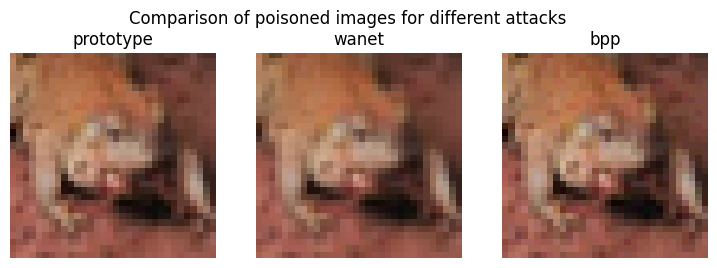

In [284]:
compare_poisoned_images(record_dict[MODEL_ARCH][DATASET], DEFAULT_POISON_RATE, train=False, transformed=False, index=IMG_INDEX_DICT[DATASET]["test"])

### Training dataset images

In [285]:
def compare_poisoned_images_train(atks, record_dict_atks):
    contains_trigger = lambda trainset: np.logical_or(trainset.poison_lookup, trainset.cross_lookup) 

    trigger_lookups = [contains_trigger(record_dict_atks[atk][DEFAULT_POISON_RATE(atk)]["train"]) for atk in atks if atk != "prototype"]
    contains_trigger_all = np.logical_and.reduce(trigger_lookups)
    trigger_indices = np.argwhere(contains_trigger_all).squeeze()
    
    for i, idx in enumerate(IMG_INDEX_DICT[DATASET]["train"]):
        compare_poisoned_images(record_dict_atks, DEFAULT_POISON_RATE, train=True, index=trigger_indices[idx], save_suffix=i, save=False)

if adap != [] or narcissus != []:
    train_subset = ["prototype"] + adap + narcissus
    record_dict_train = dict_subset(record_dict[MODEL_ARCH][DATASET], train_subset)
    compare_poisoned_images_train(train_subset, record_dict_train)

### TAC plots

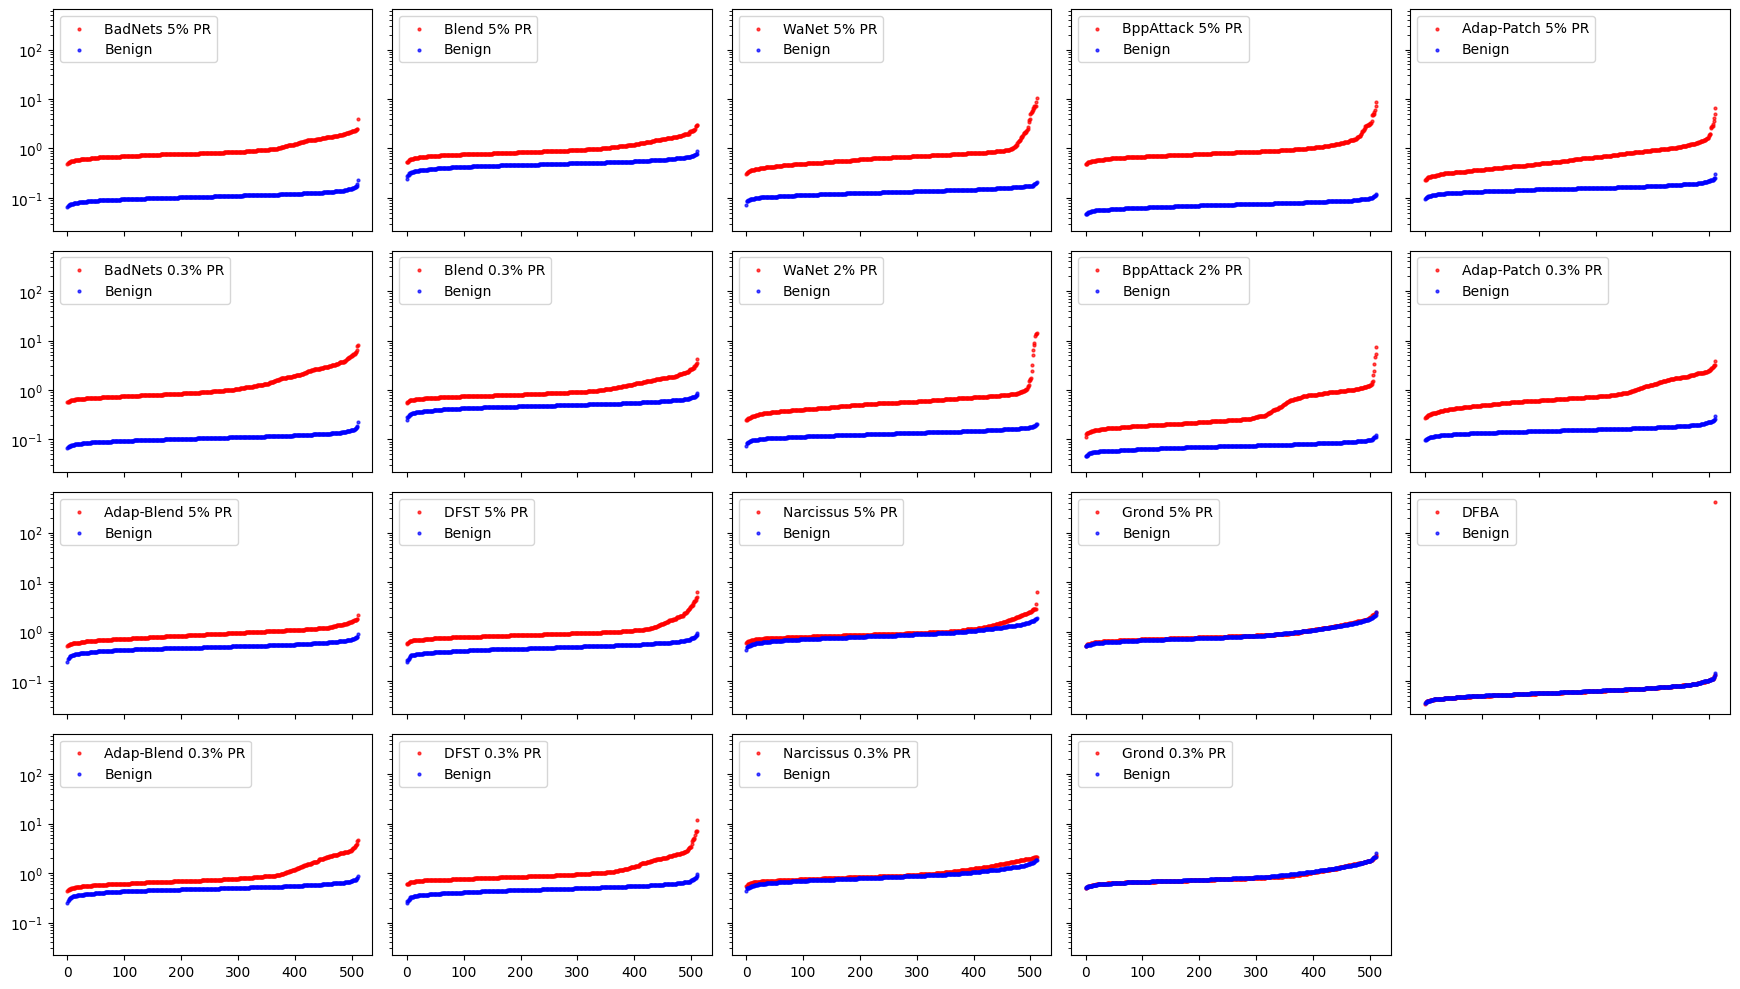

In [306]:
TAC_comparison(record_dict, MODEL_ARCH, DATASET)

# Extra input-space experiments

## SSIM on BadNets vs DFBA

In [287]:
index = 0

testset_clean = record_dict[MODEL_ARCH][DATASET]["prototype"]["test"]
img_clean, _ = testset_clean[index]

testset_badnets = record_dict[MODEL_ARCH][DATASET]["badnet"][0.05]["test"]
img_badnets, _ = testset_badnets[index]

testset_dfba = record_dict[MODEL_ARCH][DATASET]["dfba"]["test"]
img_dfba, _ = testset_dfba[index]

KeyError: 'badnet'

In [ ]:

fig, ax = plt.subplots(1,2, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)
atks = ["BadNets", "DFBA"]

for i, img in enumerate([img_badnets, img_dfba]):
    _, ssim = structural_similarity(img.numpy(), img_clean.numpy(), data_range=1, channel_axis=0, full=True)
    plot = ax[i].imshow(ssim.mean(axis=0), cmap="gray", vmin=0, vmax=1)
    ax[i].set_title(atks[i])

cax = fig.add_axes([ax[1].get_position().x1+0.06, ax[1].get_position().y0, 0.02, ax[1].get_position().height])
cbar = plt.colorbar(plot, cax=cax, ticks=[0,1], label="SSIM")

if DATASET == "cifar10":
    plt.savefig(os.path.join(RESULT_DIR, "ssim_badnets_dfba.png"), bbox_inches='tight')

plt.show()

## SAM on BadNets, DFBA, WaNet and Bpp

In [ ]:
testset_wanet = record_dict[MODEL_ARCH][DATASET]["wanet"][0.05]["test"]
testset_bpp = record_dict[MODEL_ARCH][DATASET]["bpp"][0.05]["test"]

In [ ]:
n_samples = len(testset_clean)
atks = ["BadNets", "DFBA", "WaNet", "BppAttack"]
avg_sam = torch.zeros([len(atks)] + list(IMG_SIZE_DICT[DATASET]))

for i in tqdm(range(n_samples)):
    img_clean, _ = testset_clean[i]
    img_badnets, _ = testset_badnets[i]
    img_dfba, _= testset_dfba[i]
    img_wanet, _ = testset_wanet[i]
    img_bpp, _ = testset_bpp[i]
    
    for j, img in enumerate([img_badnets, img_dfba, img_wanet, img_bpp]):
        sam = spectral_angle_mapper(img.unsqueeze(0).clamp(1e-8, 1), img_clean.unsqueeze(0).clamp(1e-8, 1), reduction='none').squeeze()
        avg_sam[j] += sam

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(5)

for row_idx in range(2):
    sam1 = avg_sam[row_idx * 2] / n_samples
    sam2 = avg_sam[row_idx * 2 + 1] / n_samples
    max_sam = max(sam1.max(), sam2.max())

    for col_idx, sam in enumerate([sam1, sam2]):
        plot = ax[row_idx][col_idx].imshow(sam, cmap="gray", vmin=0, vmax=max_sam)
        ax[row_idx][col_idx].set_title(atks[row_idx * 2 + col_idx])

    ax2 = ax[row_idx][1]
    cax = fig.add_axes([ax2.get_position().x1+0.07, ax2.get_position().y0, 0.02, ax2.get_position().height])
    cbar = plt.colorbar(plot, cax=cax, label="SAM")

if DATASET == "cifar10":
    plt.savefig(os.path.join(RESULT_DIR, "sam_per_pixel.png"), bbox_inches='tight')

plt.show()

## MSE and SSIM on Blend

In [ ]:
avg_squared_diff_dict = {}
avg_ssim_dict = {}

for dataset in DATASETS:
    avg_squared_diff = torch.zeros((3,) + IMG_SIZE_DICT[dataset])
    avg_ssim = torch.zeros((3,) + IMG_SIZE_DICT[dataset])
    testset_clean = record_dict[MODEL_ARCH][dataset]["prototype"]["test"]
    testset_blend = record_dict[MODEL_ARCH][dataset]["blended"][0.05]["test"]
    n_samples = len(testset_clean)

    for i in tqdm(range(n_samples)):
        img_clean, _ = testset_clean[i]
        img_blend, _ = testset_blend[i]

        squared_diff = np.power(img_blend - img_clean, 2)
        _, ssim = structural_similarity(img_blend.numpy(), img_clean.numpy(), data_range=1, channel_axis=0, full=True)
        avg_squared_diff += squared_diff
        avg_ssim += ssim

    avg_squared_diff_dict[dataset] = (avg_squared_diff / n_samples).mean(dim=0)
    avg_ssim_dict[dataset] = (avg_ssim / n_samples).mean(dim=0)

In [ ]:
n_datasets = len(DATASETS)
fig, axs = plt.subplots(n_datasets, 3, squeeze=False)
fig.set_figheight(6)
fig.set_figwidth(9)

TRIGGER_DICT = {
    "cifar10": "hellokitty_32.png",
    "cifar100": "hellokitty_32.png",
    "imagenette": "hellokitty_80.png"
}

DATASET_PPRINT_DICT = {
    "cifar10": "CIFAR-10",
    "cifar100": "CIFAR-100",
    "imagenette": "Imagenette",
}

# Turn off ticks in plots
for ax in axs.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])

# Show trigger for each dataset
for row_idx, dataset in enumerate(DATASETS):
    trigger_path = os.path.join("adap", "triggers", TRIGGER_DICT[dataset])
    trigger = Image.open(trigger_path)
    axs[row_idx][0].imshow(trigger)
    axs[row_idx][0].set_ylabel(DATASET_PPRINT_DICT[dataset], rotation=90, size="larger")

# Show MSE and SSIM measurements for each dataset
for i, (measurement_dict, label) in enumerate([(avg_squared_diff_dict, "Squared error"), (avg_ssim_dict, "SSIM")]):
    max_measurement = max([measurements.max() for measurements in measurement_dict.values()])
    min_measurement = max([measurements.min() for measurements in measurement_dict.values()])

    for row_idx, dataset in enumerate(DATASETS):
        measurements = measurement_dict[dataset]
        plot = axs[row_idx][i+1].imshow(measurements, cmap="gray", vmin=min_measurement, vmax=max_measurement)

    ax2 = axs[n_datasets-1][i+1]
    cax = fig.add_axes([ax2.get_position().x0, ax2.get_position().y0 - 0.05, ax2.get_position().width, 0.02])
    cbar = plt.colorbar(plot, cax=cax, label=label, orientation="horizontal")

if "cifar10" in DATASETS and "imagenette" in DATASETS:
    plt.savefig(os.path.join(RESULT_DIR, "blend_mse_ssim.png"), bbox_inches='tight')

plt.show()


## SAM on each Adap-Patch trigger

In [ ]:
# This code separates the poisoned samples for each trigger
# It does not work for the Imagenette dataset, since we changed the way the trigger is selected
clean_trainset = record_dict[MODEL_ARCH][DATASET]["prototype"]["train"]
adap_trainset = record_dict[MODEL_ARCH][DATASET]["adaptive_patch"][0.05]["train"]
poison_indices = np.argwhere(adap_trainset.poison_lookup).squeeze()
n_poison = len(poison_indices)
n_triggers = 4
poison_indices_per_trigger = [[] for _ in range(n_triggers)]

for i, p in enumerate(poison_indices):
    for j in range(n_triggers):
        if i < (j + 1) * (n_poison / n_triggers):
            poison_indices_per_trigger[j].append(p)
            break

In [ ]:
for i in range(n_triggers):
    trigger_indices = poison_indices_per_trigger[i]
    fig, ax = plt.subplots(1, 2)
    img1, _ = adap_trainset.__getitem__(trigger_indices[0])
    img2, _ = adap_trainset.__getitem__(trigger_indices[-1])
    ax[0].imshow(img1.permute(1,2,0))
    ax[1].imshow(img2.permute(1,2,0))
    plt.show()

In [ ]:
trigger_names = ["Phoenix Corner", "Firefox", "BadNets", "Trojan Square"]
sam_table = init_table(trigger_names, ["MSE", "SAM"])

for i, trigger in enumerate(trigger_names):
    trigger_indices = poison_indices_per_trigger[i]
    clean_dl = torch.utils.data.DataLoader(clean_trainset, batch_sampler=[trigger_indices])
    trigger_dl = torch.utils.data.DataLoader(adap_trainset, batch_sampler=[trigger_indices])
    clean_images, _ = next(iter(clean_dl))
    trigger_images, _ = next(iter(trigger_dl))
    sam_table.at[trigger, "MSE"] = MSE(clean_images, trigger_images)
    sam_table.at[trigger, "SAM"] = SAM(clean_images, trigger_images)

if DATASET == "cifar10":
    results_to_csv(sam_table, "sam_adap-patch", MODEL_ARCH, DATASET)

sam_table

# Presentation

## Save CIFAR-10 images

In [ ]:
cleanset = record_dict[MODEL_ARCH][DATASET]["prototype"]["test"]
bdset = record_dict[MODEL_ARCH][DATASET]["badnet"][0.05]["test"]

for i in range(1, 10):
    c_filter = np.array(cleanset.targets) == i
    indices = np.argwhere(c_filter).squeeze()[:20]
    print(np.array2string(indices, separator=','))

In [ ]:
indices = [  9, 12, 20, 24, 30, 34, 40, 42, 45, 69, 82,120,123,126,138,142,154,155,
 156,158]

f, ax = plt.subplots(1, 20)
f.set_figheight(15)
f.set_figwidth(15)

for i in range(20):
    img, _ = cleanset[indices[i]]

    ax[i].imshow(img.permute(1,2,0))
    ax[i].set_title(indices[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [ ]:
test = [9, 48, 89, 4, 14, 205, 83, 61, 209]
list(reversed(test))

In [ ]:
for idx in [209, 61, 83, 205, 14, 4, 89, 48, 9]:
    clean, label = cleanset[idx]
    bd, _ = bdset[idx]
    label = cleanset.classes[label]


    for img, desc in zip([clean, bd], ["clean", "poisoned"]):
        to_pil = T.ToPILImage()
        to_pil(img).save(f"/home/henk/master-thesis/presentation/figures/badnets/{label}_{desc}.png")

## Illustrate STRIP

In [ ]:
path = "/home/henk/master-thesis/presentation/figures/badnets"

bd = Image.open(os.path.join(path, "frog_poisoned.png"))
clean = Image.open(os.path.join(path, "frog_clean.png"))
to_tensor = T.ToTensor()

for img, desc in zip([clean, bd], ["clean", "poisoned"]):
    for i in range(1, 4):
        val = Image.open(os.path.join(path, f"val{i}.png"))
        blend = (to_tensor(img) + to_tensor(val)) / 2
        blend = to_pil(blend)
        blend.save(os.path.join(path, f"blend_{desc}_{i}.png"))

## Illustrate Bpp

In [ ]:
path = "/home/henk/master-thesis/presentation/figures"

bd = Image.open(os.path.join(path, "bpp", "frog_poisoned.png"))
clean = Image.open(os.path.join(path, "badnets", "frog_clean.png"))

In [ ]:
f, ax = plt.subplots(4)
img = bd
d = 5
color_range = 2**d - 1
colorbar_height = 10

ax[0].imshow(img)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].axis('off')

for i, c in enumerate(['R', 'G', 'B']):
    rgb = np.zeros((colorbar_height, 256, 3))
    rgb[:, :, i] = np.arange(0, 256).reshape((1, 256))

    # Quantization
    rgb = np.round(rgb / 255 * color_range) / color_range * 255

    idx = i+1
    ax[idx].imshow(rgb / 256)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_ylabel(c, rotation=0)
    bbox = ax[idx].get_position
    ax[idx].set_position([0.25, 0.205 - i * 0.01, 0.525, 1])
    ax[idx].yaxis.set_label_coords(-0.03, 0)

    f.set_figheight(20)

plt.savefig(os.path.join(path, "bpp", f"d={d}.png"), transparent=True, bbox_inches='tight', pad_inches=0.05)

## Save t-SNE embeddings with green benign samples

In [ ]:
for atk in ATTACKS:
    for pr in [0.003, 0.05]:
        atk_id = f"{atk}_p{pr}"
        trainset = record_dict[MODEL_ARCH][DATASET][atk][pr]["train_transformed"]
        train_path = os.path.join(RESULT_DIR, "feature_space_train", f"{MODEL_ARCH}_{DATASET}", f"{atk_id}.pt")
        tsne_path = os.path.join("/home/henk/master-thesis/presentation/figures/tsne", atk_id)
        
        create_tsne(trainset, train_path, save_dst=tsne_path)

## Adap-Patch images

In [ ]:
adap_trainset = record_dict[MODEL_ARCH][DATASET]["adaptive_patch"][0.05]["train"]
clean_trainset = record_dict[MODEL_ARCH][DATASET]["prototype"]["train"]

for trainset, desc in zip([clean_trainset, adap_trainset], ["clean", "poisoned"]):
    indices = [1243, 1694, 16352, 36026, 47244, 47358, 1596, 16868, 35671, 47269]

    for i, idx in enumerate(indices):
        img, _ = trainset[idx]
        label = trainset.classes[i]
        to_pil = T.ToPILImage()
        to_pil(img).save(f"/home/henk/master-thesis/presentation/figures/adaptive_patch/{label}_{desc}.png")

## Adap-Patch CDBI

In [ ]:
tsne_path = "/home/henk/master-thesis/thesis/code_results/tsne/resnet18_cifar10/adaptive_patch_p0.05/embedding.pt"
tsne_dict = torch.load(tsne_path, weights_only=False)
cdbi, dbis = CDBI(tsne_dict["features_benign"], 
                  tsne_dict["features_poisoned"], 
                  tsne_dict["gt_labels_poisoned"])

In [ ]:
cdbi

In [ ]:
class_colors = ['#B82B22',
                '#CE2658',
                '#E11F8D',
                '#F114C5',
                '#FF00FF',
                '#CA5E23',
                '#DA8723',
                '#E8AF1F',
                '#F4D717',
                '#FFFF00']

for i, color in enumerate(class_colors):
    print(f"\\definecolor{{poison{i+1}}}{{HTML}}{{{color[1:]}}}")

In [ ]:
for i, dbi in enumerate(dbis):
    print(f"& \\textcolor{{poison{i+1}}}{{{"{0:#.2g}".format(dbi)}}}\\\\")

In [ ]:
sum(dbis)